<a href="https://colab.research.google.com/github/dileepyadavns/multivaraiate_time_series_forecasting/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import numpy as np
import pandas as pd
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import matplotlib.pyplot as plt
# from pandas import read_csv
# from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM

In [76]:
dataset_train = pd.read_csv('/content/train.csv',header=0, index_col=0)  
dataset_train.head(2)

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0


In [77]:
print(type(dataset_train))
dataset_train.shape

<class 'pandas.core.frame.DataFrame'>


(43775, 16)

In [78]:
dataset_columns = dataset_train.columns.tolist()
dataset_columns

['nat_demand',
 'T2M_toc',
 'QV2M_toc',
 'TQL_toc',
 'W2M_toc',
 'T2M_san',
 'QV2M_san',
 'TQL_san',
 'W2M_san',
 'T2M_dav',
 'QV2M_dav',
 'TQL_dav',
 'W2M_dav',
 'Holiday_ID',
 'holiday',
 'school']

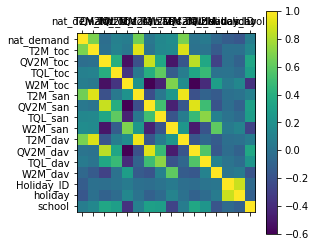

In [79]:
cor_cols = dataset_columns
plt.matshow(dataset_train.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

In [80]:
values = dataset_train.values
print(values.shape)
print(type(values))
values[0]

(43775, 16)
<class 'numpy.ndarray'>


array([9.70345000e+02, 2.58652588e+01, 1.85763820e-02, 1.61743160e-02,
       2.18505458e+01, 2.34824463e+01, 1.72717550e-02, 1.85537300e-03,
       1.03289487e+01, 2.26621338e+01, 1.65622220e-02, 9.60998500e-02,
       5.36414795e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [150]:
# normalized the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)
print(scaled_dataset[0])
scaled_dataset.shape

[0.5409399  0.24092133 0.61321832 0.03103044 0.55688809 0.19262007
 0.59236179 0.00380735 0.42043586 0.19103092 0.61106557 0.20105082
 0.52063079 0.         0.         0.        ]


(43775, 16)

In [82]:
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (43771, 1)
X (43771, 4, 16)


In [83]:
X[0][0]

array([0.5409399 , 0.24092133, 0.61321832, 0.03103044, 0.55688809,
       0.19262007, 0.59236179, 0.00380735, 0.42043586, 0.19103092,
       0.61106557, 0.20105082, 0.52063079, 0.        , 0.        ,
       0.        ])

In [84]:
X[0][1]

array([0.50539099, 0.24373419, 0.62044905, 0.03149883, 0.56495521,
       0.18830926, 0.5917586 , 0.00271794, 0.43487148, 0.18520624,
       0.60639517, 0.18335602, 0.54090872, 0.        , 0.        ,
       0.        ])

In [85]:
X[0][2]

array([0.49811449, 0.24688035, 0.63122022, 0.02969848, 0.57229741,
       0.18542169, 0.58717608, 0.00292638, 0.44279035, 0.18185159,
       0.60370644, 0.16470301, 0.569985  , 0.        , 0.        ,
       0.        ])

In [86]:
X[0][3]

array([0.49181073, 0.24855696, 0.64270863, 0.03122073, 0.56351557,
       0.17999443, 0.5799688 , 0.00534018, 0.4282018 , 0.18053538,
       0.60439262, 0.14304764, 0.57119564, 0.        , 0.        ,
       0.        ])

In [87]:
#Splitting the dataset
n_train = 24*365
train_X, test_X = X[n_train:,] , X[:n_train,]
print('train_X' ,train_X.shape)
print('test_X' ,test_X.shape)

train_y, test_y = Y[n_train:,] , Y[:n_train,]
print('train_y' ,train_y.shape)
print('test_y' ,test_y.shape)

train_X (35011, 4, 16)
test_X (8760, 4, 16)
train_y (35011, 1)
test_y (8760, 1)


In [88]:
train_y

array([[0.4973438 ],
       [0.47749485],
       [0.48078521],
       ...,
       [0.67742589],
       [0.63878884],
       [0.61068694]])

In [89]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
487/487 - 5s - loss: 0.0856 - val_loss: 0.0950 - 5s/epoch - 10ms/step
Epoch 2/50
487/487 - 2s - loss: 0.0592 - val_loss: 0.0765 - 2s/epoch - 5ms/step
Epoch 3/50
487/487 - 2s - loss: 0.0516 - val_loss: 0.0581 - 2s/epoch - 5ms/step
Epoch 4/50
487/487 - 2s - loss: 0.0447 - val_loss: 0.0355 - 2s/epoch - 5ms/step
Epoch 5/50
487/487 - 2s - loss: 0.0388 - val_loss: 0.0353 - 2s/epoch - 5ms/step
Epoch 6/50
487/487 - 2s - loss: 0.0342 - val_loss: 0.0234 - 2s/epoch - 5ms/step
Epoch 7/50
487/487 - 2s - loss: 0.0313 - val_loss: 0.0283 - 2s/epoch - 5ms/step
Epoch 8/50
487/487 - 2s - loss: 0.0288 - val_loss: 0.0357 - 2s/epoch - 5ms/step
Epoch 9/50
487/487 - 2s - loss: 0.0275 - val_loss: 0.0277 - 2s/epoch - 5ms/step
Epoch 10/50
487/487 - 2s - loss: 0.0251 - val_loss: 0.0215 - 2s/epoch - 5ms/step
Epoch 11/50
487/487 - 2s - loss: 0.0239 - val_loss: 0.0262 - 2s/epoch - 5ms/step
Epoch 12/50
487/487 - 2s - loss: 0.0231 - val_loss: 0.0369 - 2s/epoch - 5ms/step
Epoch 13/50
487/487 - 2s - loss: 0.0

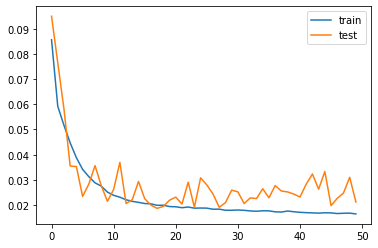

In [90]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [91]:
Y_pred = model.predict(test_X)

mse = mean_squared_error(test_y, Y_pred)

rmse = np.sqrt(mse)
rmse

0.026508543561909546

In [119]:
d = scaled_dataset[:8760,:]
Y_predicted = np.concatenate((Y_pred,d[:8760,1:]), axis =1)
# print('concat y_pred',Y_pred.shape)
print(Y_predicted[0])
Y_tested = np.concatenate((test_y, d[:8760,1:]), axis = 1)
# print('concat Y_test', test_y.shape)

[0.51417685 0.24092133 0.61321832 0.03103044 0.55688809 0.19262007
 0.59236179 0.00380735 0.42043586 0.19103092 0.61106557 0.20105082
 0.52063079 0.         0.         0.        ]


In [157]:
#Scaling back to the original scale
Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (740, 1)
Y_predicted (740, 1)


In [158]:
print(Y_predicted)

[[ 103945.2937731 ]
 [  76085.33763467]
 [  61629.57505007]
 [ 102679.06996217]
 [ 465266.58323599]
 [ 413974.78362084]
 [ 388815.16865722]
 [ 365750.71202355]
 [ 321619.76395523]
 [ 286208.42820527]
 [ 267917.7662064 ]
 [ 271913.0582259 ]
 [ 274983.02056861]
 [ 312907.01420605]
 [ 376637.61944556]
 [ 347396.85055037]
 [ 277836.89177948]
 [ 213918.12446873]
 [ 168084.94005464]
 [ 149216.54548764]
 [ 134560.97042367]
 [ -28976.76623184]
 [ 109142.49296681]
 [ 206214.17238894]
 [ 206342.3268785 ]
 [ 192046.63770987]
 [ 184232.72492857]
 [ 221796.19429213]
 [ 729635.96904813]
 [ 493804.97615539]
 [ 413750.2339735 ]
 [ 395000.2586235 ]
 [ 362387.09555781]
 [ 358734.13402412]
 [ 349687.67189926]
 [ 333856.36318075]
 [ 357680.80945239]
 [ 388249.56528112]
 [ 419151.23551238]
 [ 375450.55457215]
 [ 276734.25246643]
 [ 248508.82462054]
 [ 208420.24898819]
 [ 186223.50836914]
 [ 173921.6349391 ]
 [ 149111.05343583]
 [ 129984.11556486]
 [ 124171.67906448]
 [ 126338.01660034]
 [ 125645.53549175]


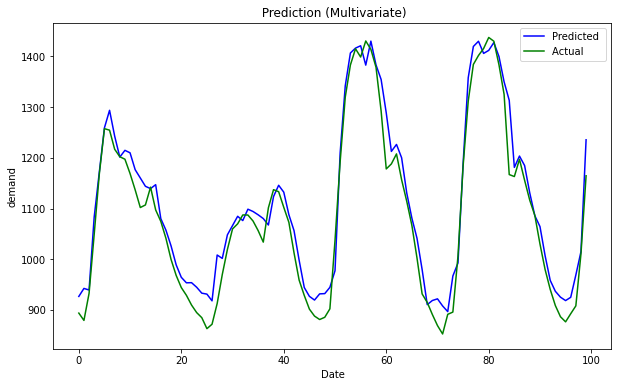

<Figure size 432x288 with 0 Axes>

In [94]:
#Plot the graph between actual vs predicted values
pyplot.figure(figsize=(10,6))  
pyplot.plot(Y_predicted[:100,:], color= 'blue',label = 'Predicted ')
pyplot.plot(Y_tested[:100,:] , color = 'green',label = 'Actual ')
pyplot.title(" Prediction (Multivariate)")
pyplot.xlabel("Date")
pyplot.ylabel("demand")
pyplot.legend()
pyplot.show()
pyplot.savefig('graph.png')

In [151]:
df2=pd.read_csv("/content/Test.csv",header=0 ,index_col=0)

In [152]:
df2

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
01-01-2020 00:00,0,25.809259,0.018042,0.032806,14.849625,23.301447,0.017035,0.021866,4.559083,22.598322,0.016195,0.068054,3.737708,1,1,0
01-01-2020 01:00,0,25.650842,0.018065,0.053177,15.933757,23.041467,0.016936,0.023796,4.846412,22.471155,0.016104,0.080109,3.591759,1,1,0
01-01-2020 02:00,0,25.501489,0.018119,0.069000,16.806818,22.806177,0.016822,0.024910,5.204608,22.368677,0.016013,0.094757,3.704177,1,1,0
01-01-2020 03:00,0,25.430994,0.018142,0.080017,17.460632,22.657556,0.016746,0.025208,5.628076,22.282556,0.015937,0.107086,3.936592,1,1,0
01-01-2020 04:00,0,25.360132,0.018204,0.084137,16.632112,22.539819,0.016647,0.022789,5.729821,22.203882,0.015862,0.113800,4.088643,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31-01-2020 19:00,0,26.784631,0.017690,0.010593,19.426609,25.604944,0.017454,0.061157,6.729619,23.565881,0.015554,0.007301,2.361485,0,0,0
31-01-2020 20:00,0,26.414575,0.017881,0.008904,17.925048,24.805200,0.017110,0.051682,7.381728,22.813013,0.015466,0.010132,3.400858,0,0,0
31-01-2020 21:00,0,26.165247,0.017990,0.008423,16.726263,24.149622,0.016761,0.041794,7.395275,22.219934,0.015453,0.012619,3.984798,0,0,0


In [97]:
values1 = df2.values
print(values1.shape)
print(type(values1))
values1[0]

(744, 16)
<class 'numpy.ndarray'>


array([0.00000000e+00, 2.58092590e+01, 1.80415900e-02, 3.28063960e-02,
       1.48496246e+01, 2.33014465e+01, 1.70345100e-02, 2.18658450e-02,
       4.55908335e+00, 2.25983215e+01, 1.61952770e-02, 6.80542000e-02,
       3.73770774e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00])

In [149]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset1 = scaler.fit_transform(values1)
scaled_dataset1[2]


array([0.        , 0.23532473, 0.6464039 , 0.25415917, 0.35777328,
       0.1881214 , 0.3618014 , 0.07764455, 0.23638085, 0.17034491,
       0.48496713, 0.27706844, 0.4730114 , 0.5       , 1.        ,
       0.        ])

In [146]:
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    print(train[i,0:1])
  return X,Y
X1, Y1 = to_supervised(scaled_dataset1)
X1 = np.array(X1)
Y1 = np.array(Y1)
print('Y' ,Y1.shape)
print('X' ,X1.shape)
print('sd',scaled_dataset1.shape)

[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [103]:
print(X1.shape)
print(Y1.shape)

(740, 4, 16)
(740, 1)


In [109]:
Y_pred1 = model.predict(X1)
print(Y_pred1.shape)
mse = mean_squared_error(Y1, Y_pred1)

rmse = np.sqrt(mse)
rmse

(740, 1)


0.08314801520741981

In [145]:
Y1

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [140]:

d = scaled_dataset1[:740,:]
Y_predicted1 = np.concatenate((Y_pred1,d[:,1:]), axis =1)
print(Y_predicted1[0])
Y_tested1 = np.concatenate((Y1, d[:740,1:]), axis = 1)
print('concat y_pred',Y_pred1.shape)


[-0.01327419  0.27697384  0.62861336  0.12084082  0.27604569  0.23374064
  0.40387961  0.06812787  0.20115433  0.20007507  0.52078579  0.19869338
  0.47764782  0.5         1.          0.        ]
concat y_pred (740, 1)


In [141]:
Y_predicted = scaler.inverse_transform(Y_predicted1)
Y_tested = scaler.inverse_transform(Y_tested1)
Y_predicted1 = Y_predicted1[:,0:1]
Y_tested1 = Y_tested1[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (740, 16)
Y_predicted (740, 16)


In [154]:
print(Y_predicted1)

[[-1.32741928e-02]
 [-2.36791968e-02]
 [-2.90780663e-02]
 [-1.37470961e-02]
 [ 1.21670365e-01]
 [ 1.02514148e-01]
 [ 9.31176543e-02]
 [ 8.45036507e-02]
 [ 6.80218339e-02]
 [ 5.47965765e-02]
 [ 4.79654670e-02]
 [ 4.94576097e-02]
 [ 5.06041646e-02]
 [ 6.47678375e-02]
 [ 8.85696411e-02]
 [ 7.76489377e-02]
 [ 5.16700149e-02]
 [ 2.77979374e-02]
 [ 1.06803775e-02]
 [ 3.63349915e-03]
 [-1.83999538e-03]
 [-6.29172921e-02]
 [-1.13331676e-02]
 [ 2.49207020e-02]
 [ 2.49685645e-02]
 [ 1.96294785e-02]
 [ 1.67111754e-02]
 [ 3.07402015e-02]
 [ 2.20405787e-01]
 [ 1.32328749e-01]
 [ 1.02430284e-01]
 [ 9.54276323e-02]
 [ 8.32474232e-02]
 [ 8.18831325e-02]
 [ 7.85045028e-02]
 [ 7.25919008e-02]
 [ 8.14897418e-02]
 [ 9.29064155e-02]
 [ 1.04447424e-01]
 [ 8.81263018e-02]
 [ 5.12582064e-02]
 [ 4.07167077e-02]
 [ 2.57446170e-02]
 [ 1.74546838e-02]
 [ 1.28602386e-02]
 [ 3.59410048e-03]
 [-3.54933739e-03]
 [-5.72013855e-03]
 [-4.91106510e-03]
 [-5.16968966e-03]
 [ 1.91920996e-03]
 [ 2.42494345e-02]
 [ 2.2676897

In [144]:
print(Y_tested1)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

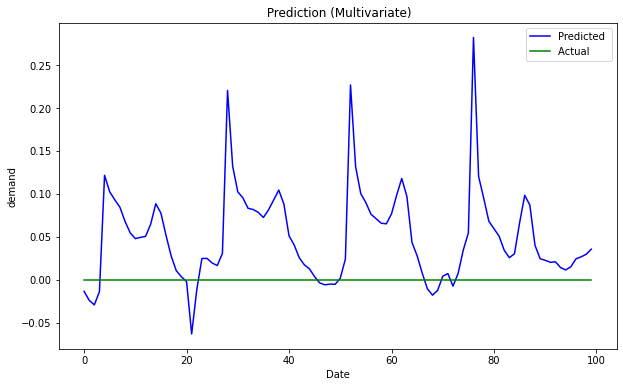

<Figure size 432x288 with 0 Axes>

In [142]:
pyplot.figure(figsize=(10,6))  
pyplot.plot(Y_predicted1[:100,:], color= 'blue',label = 'Predicted ')
pyplot.plot(Y_tested1[:100,:] , color = 'green',label = 'Actual ')
pyplot.title(" Prediction (Multivariate)")
pyplot.xlabel("Date")
pyplot.ylabel("demand")
pyplot.legend()
pyplot.show()
pyplot.savefig('graph.png')